# Link Prediction using DGL

This notebook uses the Python Library DGL for friend recommendation. 

Some of the code is adapted from the following tutorial for link prediction: https://docs.dgl.ai/en/0.6.x/tutorials/blitz/4_link_predict.html#sphx-glr-tutorials-blitz-4-link-predict-py

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
from time import time
import pandas as pd
import dgl
import os

## Dataset Loading

We use the [Facebook social circles](https://snap.stanford.edu/data/ego-Facebook.html) dataset, available at the Stanford SNAP website, for friend recommendation.


Obviously, we need to load the friendship (edges) into the graph. The files also provide user features information, represented by a 224-dimensional vector of 0s and 1s, so we load that as well. For the simplicity of this tutorial, we will only use one ego network (e.g. User 0's network).

In [2]:
def get_user(x):
    return x[0]

user_data = pd.Series(np.char.split(np.array(os.listdir('./facebook_data')), sep='.'))
user_ls = np.unique(np.array(user_data.apply(get_user)))
user_ls

array(['0', '107', '1684', '1912', '3437', '348', '3980', '414', '686',
       '698'], dtype=object)

In [3]:
# user id, which correspond to file name prefix
USER = 0

file_edges = f'facebook_data/{USER}.edges'
file_feat = f'facebook_data/{USER}.feat'

edges_u, edges_v = [], []

with open(file_edges) as f:  # load edges file
    for line in f:
        e1, e2 = tuple(int(x) - 1 for x in line.split())
        edges_u.append(e1)
        edges_v.append(e2)

edges_u, edges_v = np.array(edges_u), np.array(edges_v)

num_nodes = 0  # assumes nodes are sequential
feats = []  # node features

with open(file_feat) as f:  # load node features file
    for line in f:
        num_nodes += 1
        a = [int(x) for x in line.split()[1:]]
        feats.append(torch.tensor(a, dtype=torch.float))

feats = torch.stack(feats)
# print(feats.shape)

g = dgl.graph((edges_u, edges_v))  # construct graph
g.ndata['feat'] = feats

g

Graph(num_nodes=347, num_edges=5038,
      ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32)}
      edata_schemes={})

## Graph Visualization

We use the networkx library for visualizing the friendship relationships. There are hundreds of nodes (not shown), and thousands of links, so it can seem a bit messy when the graph is drawn.

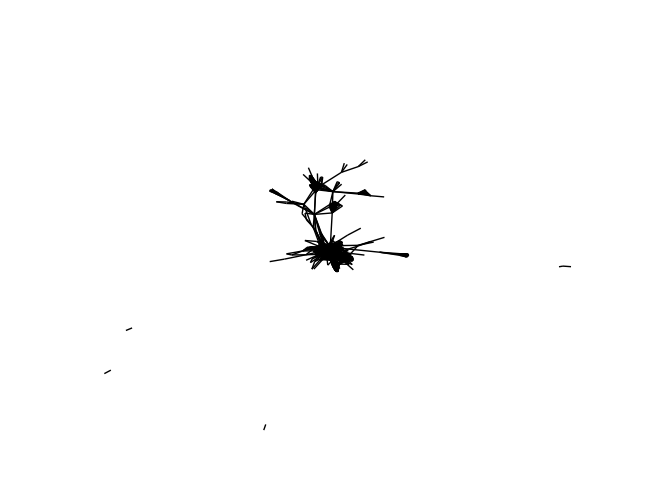

In [4]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(set(edges_u + edges_v))
G.add_edges_from(zip(edges_u, edges_v))

nx.draw(G, node_size=0)

## Training/testing data construction

Once we have the graph constructed, we can split it into the training set and testing set. We omit the validation set for simplicity.

We construct a graph of "negative edges"; whenever there is a lack of an edges between two nodes `u` and `v` in the original graph, there is a corresponding edge in the negative graph. This is needed for telling the training algorithm what the "negative examples" are.

We randomly split 30% of links for testing, and leave 70% for training.

In [5]:
TEST_RATIO = 0.3

u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * TEST_RATIO)
train_size = g.number_of_edges() - test_size

# get positive edges for test and train
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the negative edges for training and testing 
neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

# construct positive and negative graphs for training and testing
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# training graph
train_g = dgl.remove_edges(g, eids[:test_size])
train_g = dgl.add_self_loop(train_g)

## Model definition

Here we build two models from the existing implementation in the DGL library. Both models consists of 2 convolutional layers. 

`GCN` is a standard graph convolutional network, and serves as a baseline. `GraphSAGE` is a more advanced and powerful network that we're testing.

We also define the `DotPredictor`, which helps to predict the likelihood of whether an edge exists or not, by taking the dot product of two nodes. 

In [6]:
from dgl.nn import SAGEConv
from dgl.nn import GraphConv

# ----------- create model -------------- #
# build an ordinary GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]


## Training and testing pipeline

In [7]:
def pipeline(model_name='GCN', hidden_size=16):
    # model_name can be GCN or SAGE
    # hidden_size is the size of the hidden layer in the neural net
    if model_name == 'GCN':
        model = GCN(train_g.ndata['feat'].shape[1], hidden_size)
    elif model_name == 'SAGE':
        model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_size)
        
    pred = DotPredictor()

    def compute_loss(pos_score, neg_score):  # computes the loss based on binary cross entropy
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])

        print('Scores:', scores)
        print('Labels:', labels)
        return F.binary_cross_entropy_with_logits(scores, labels)

    def compute_auc(pos_score, neg_score):  # computes AUC (Area-Under-Curve) score
        scores = torch.cat([pos_score, neg_score]).numpy()
        labels = torch.cat(
            [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
        return roc_auc_score(labels, scores)


    # ----------- set up loss and optimizer -------------- #
    # in this case, loss will in training loop
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

    # ----------- training -------------------------------- #
    all_logits = []
    for e in range(100):
        # forward
        h = model(train_g, train_g.ndata['feat'])  # get node embeddings
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {}'.format(e, loss))

    # ----------- test and check results ---------------- #
    from sklearn.metrics import roc_auc_score
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        print('AUC', compute_auc(pos_score, neg_score))
    
    return h  # return node embeddings


### Training and testing GCN:

In [8]:
h = pipeline("GCN")

Scores: tensor([0.1035, 0.1435, 0.0843,  ..., 0.0189, 0.0275, 0.0589],
       grad_fn=<CatBackward0>)
Labels: tensor([1., 1., 1.,  ..., 0., 0., 0.])
In epoch 0, loss: 0.6874449253082275
Scores: tensor([0.8192, 0.9109, 0.4737,  ..., 0.1298, 0.1367, 0.3215],
       grad_fn=<CatBackward0>)
Labels: tensor([1., 1., 1.,  ..., 0., 0., 0.])
Scores: tensor([2.4257, 2.5819, 1.3865,  ..., 0.3597, 0.3136, 0.8315],
       grad_fn=<CatBackward0>)
Labels: tensor([1., 1., 1.,  ..., 0., 0., 0.])
Scores: tensor([2.2778, 2.3517, 1.0507,  ..., 0.3057, 0.2340, 0.5859],
       grad_fn=<CatBackward0>)
Labels: tensor([1., 1., 1.,  ..., 0., 0., 0.])
Scores: tensor([1.9235, 1.8989, 0.6141,  ..., 0.2208, 0.1310, 0.2827],
       grad_fn=<CatBackward0>)
Labels: tensor([1., 1., 1.,  ..., 0., 0., 0.])
Scores: tensor([1.9825, 1.8461, 0.3450,  ..., 0.1894, 0.0518, 0.0868],
       grad_fn=<CatBackward0>)
Labels: tensor([1., 1., 1.,  ..., 0., 0., 0.])
In epoch 5, loss: 0.5765877366065979
Scores: tensor([ 2.5613,  2.2790

### Training and testing SAGE:

In [10]:
h = pipeline("SAGE")

In epoch 0, loss: 1.185091495513916
In epoch 5, loss: 0.6183627843856812
In epoch 10, loss: 0.5766068696975708
In epoch 15, loss: 0.5462220311164856
In epoch 20, loss: 0.5231993794441223
In epoch 25, loss: 0.5026652216911316
In epoch 30, loss: 0.489641398191452
In epoch 35, loss: 0.47622647881507874
In epoch 40, loss: 0.46585485339164734
In epoch 45, loss: 0.45505568385124207
In epoch 50, loss: 0.44496604800224304
In epoch 55, loss: 0.43537989258766174
In epoch 60, loss: 0.42571908235549927
In epoch 65, loss: 0.415399432182312
In epoch 70, loss: 0.40556761622428894
In epoch 75, loss: 0.39651331305503845
In epoch 80, loss: 0.3878096640110016
In epoch 85, loss: 0.37894803285598755
In epoch 90, loss: 0.37082192301750183
In epoch 95, loss: 0.36288997530937195
AUC 0.9054745674889767


# Friend recommendation

Once we trained our model, we can finally suggest friends. To do this, we calculate the embedding dot products between a given user and all other users that he/she is currently NOT friends with. Then we choose 5 users with the highest dot product scores to recommend to him/her.

In [18]:
# --------- generate recommendation for user -------- #
def generate_rec(h, user_id=0, num_pred=5):
    # `h` represents the node embeddings, with shape [num_nodes, hidden_size]

    # generate a graph with (num_nodes - num_friends_of_user) edges
    # one end of the edge is user_id
    # the other end is a user that's NOT friends with user_id
    user_friends = set()
    user_neg_u, user_neg_v = [], []
    for n1, n2 in zip(u, v):   # get all friends of user_id
        if int(n1) == user_id:
            user_friends.add(int(n2))
        if int(n2) == user_id:
            user_friends.add(int(n1))

    for i in range(num_nodes):  # generate "negative edges" for user_id
        if i != user_id and i not in user_friends:
            user_neg_u.append(user_id)
            user_neg_v.append(i)
            
    user_g = dgl.graph((user_neg_u, user_neg_v), num_nodes=g.number_of_nodes())

    pred = DotPredictor()

    # calculate the score of each user
    scores = [(i, score) for i, score in enumerate(pred(user_g, h))]

    # produce final ranked list
    scores.sort(key=lambda x: -x[1])

    # display results
    print(f"List of 5 suggested friends for user {user_id}:")
    for i in range(num_pred):
        print(f'- User {scores[i][0]}, score = {scores[i][1]}')

    # data_pred = {scores[i][0]: float(scores[i][1]) for i in range(num_pred)}
    data_pred = {'User': [scores[i][0] for i in range(num_pred)],
                 'Score': [float(scores[i][1]) for i in range(num_pred)]}
    df_pred = pd.DataFrame(data=data_pred, columns=['User', 'Score'])

    return df_pred


In [19]:
df_pred = generate_rec(h, user_id=18)
df_pred

List of 5 suggested friends for user 18:
- User 205, score = 7.252294540405273
- User 132, score = 6.9791364669799805
- User 141, score = 5.800884246826172
- User 310, score = 5.4453325271606445
- User 231, score = 5.1912007331848145


,User,Score
0,205,7.252295
1,132,6.979136
2,141,5.800884
3,310,5.445333
4,231,5.191201
